In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from skimage import io

from nltk.corpus import stopwords
import string

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomCrop, ColorJitter, GaussianBlur
# import torchtext
# from torchtext.data import Field, LabelField, TabularDataset, BucketIterator

# Завдання 1

In [3]:
filename = 'heart.csv'
df = pd.read_csv(filename)

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
# приведемо всі рядкові категоріальні змінні до чисельного виду
# для того щоб можна було включити їх в моделі класифікації
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df['ChestPainType'] = label_encoder.fit_transform(df['ChestPainType'])
df['RestingECG'] = label_encoder.fit_transform(df['RestingECG'])
df['ExerciseAngina'] = label_encoder.fit_transform(df['ExerciseAngina'])
df['ST_Slope'] = label_encoder.fit_transform(df['ST_Slope'])

In [6]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [7]:
### Нормалізація даних

ignore = ['HeartDisease', 'Sex', 'ExerciseAngina', 'RestingECG', 'ChestPainType', 'ST_Slope']

# Копіюємо вихідний датасет
normalized_df = df.copy()

# Вибираємо ознаки, які потрібно нормалізувати (усі, окрім ігнорованих ознак)
features_to_normalize = [col for col in normalized_df.columns if col not in ignore]

# Ініціалізуємо StandardScaler
scaler = StandardScaler()

# Нормалізуємо вибрані ознаки в окремому датасеті
normalized_df[features_to_normalize] = scaler.fit_transform(normalized_df[features_to_normalize])

# Виводимо нормалізований датасет
normalized_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,1,1,0.410909,0.825070,-0.551341,1,1.382928,0,-0.832432,2,0
1,-0.478484,0,2,1.491752,-0.171961,-0.551341,1,0.754157,0,0.105664,1,1
2,-1.751359,1,1,-0.129513,0.770188,-0.551341,2,-1.525138,0,-0.832432,2,0
3,-0.584556,0,0,0.302825,0.139040,-0.551341,1,-1.132156,1,0.574711,1,1
4,0.051881,1,2,0.951331,-0.034755,-0.551341,1,-0.581981,0,-0.832432,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.902775,1,3,-1.210356,0.596393,-0.551341,1,-0.188999,0,0.293283,1,1
914,1.536902,1,0,0.627078,-0.053049,1.813758,1,0.164684,0,2.357094,1,1
915,0.370100,1,0,-0.129513,-0.620168,-0.551341,1,-0.857069,1,0.293283,1,1
916,0.370100,0,1,-0.129513,0.340275,-0.551341,0,1.461525,0,-0.832432,1,1


In [8]:
X = normalized_df.drop('HeartDisease', axis=1)
y = normalized_df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, y_train

(          Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
 795 -1.220994    1              2  -0.669935     0.376864   1.813758   
 25  -1.857431    1              2  -0.129513     0.093304  -0.551341   
 84   0.264027    1              0   0.951331     0.129892   1.813758   
 10  -1.751359    0              2  -0.129513     0.111598  -0.551341   
 344 -0.266338    1              0  -0.669935    -1.818435   1.813758   
 ..        ...  ...            ...        ...          ...        ...   
 106 -0.584556    0              0  -0.669935     0.504923  -0.551341   
 270 -0.902775    1              0  -0.669935     0.239657  -0.551341   
 860  0.688318    1              0  -0.129513     0.495776  -0.551341   
 435  0.688318    1              0   1.059415    -1.818435  -0.551341   
 102 -1.433140    0              0   0.951331     1.767219  -0.551341   
 
      RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  
 795           1  2.247488               0 -0.081956     

In [9]:
class HeartDiseaseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = HeartDiseaseDataset(X_train, y_train)
test_dataset = HeartDiseaseDataset(X_test, y_test)

In [10]:
def create_heart_disease_model(input_size, h1, h2, output_size):
    model = nn.Sequential(
        nn.Linear(input_size, h1),
        nn.ReLU(),
        nn.Linear(h1, h2),
        nn.ReLU(),
        nn.Linear(h2, output_size),
    )
    return model

In [11]:
def model_train(model, lr, num_epochs):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(train_dataset.X)
        optimizer.zero_grad()
        loss = criterion(outputs, train_dataset.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        
    return model

In [12]:
def torch_gridsearch():
    return

In [13]:
input_size = X_train.shape[1]
hidden_size = 64  # You can adjust this.
output_size = 1  # Since it's binary classification.
layer_dims = [input_size, 32, 16, output_size]

model = create_heart_disease_model(*layer_dims)

model_train(model, 0.01, 25)

Sequential(
  (0): Linear(in_features=11, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)

In [14]:
model.eval()
with torch.no_grad():
    test_outputs = model(test_dataset.X)
    predicted = (test_outputs >= 0).float()
    accuracy = accuracy_score(test_dataset.y, predicted)
    print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.8206521739130435


In [15]:
print(classification_report(test_dataset.y, predicted))

              precision    recall  f1-score   support

         0.0       0.74      0.87      0.80        77
         1.0       0.89      0.79      0.84       107

    accuracy                           0.82       184
   macro avg       0.82      0.83      0.82       184
weighted avg       0.83      0.82      0.82       184



# Завдання 2 (класифікація зображень)

In [16]:
# /pokemons
pokemons = pd.read_csv("pokemons/pokemon.csv")
pokemons.shape

(809, 3)

In [17]:
pokemons.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [18]:
types = ['Fire', 'Electric', 'Dark']
pokemons = pokemons[pokemons['Type1'].isin(types)][["Name", "Type1"]]

pokemons.head()

,Name,Type1
3,charmander,Fire
4,charmeleon,Fire
5,charizard,Fire
24,pikachu,Electric
25,raichu,Electric


In [19]:
pokemons.shape

(122, 2)

In [20]:
poke_types = {
    t:i for i, t in enumerate(pokemons['Type1'].unique())
}
poke_types, type(poke_types)

({'Fire': 0, 'Electric': 1, 'Dark': 2}, dict)

In [21]:
class PokemonDataset(Dataset):
    def __init__(self, image_dir, poke_names):
        """Initialize the attributes of the object of the class."""
        self.poke_names = poke_names
        self.image_dir = image_dir
        self.image_path_list = sorted(self._find_files(image_dir))
        
    def __len__(self):
        """Return the size of the dataset."""
        return len(self.image_path_list)

    def __getitem__(self, index):
        image_path = self.image_path_list[index]
        name = image_path.split("/")[-1][:-4]
        poke_type = pokemons[pokemons['Name'] == name]['Type1'].values[0]
        
        x = io.imread(image_path)
        x = torch.tensor(x).type(torch.FloatTensor)
        x = x[:, :, :3]
        x_min, x_max = torch.min(x), torch.max(x)
        normalized_x = (x - x_min) / (x_max - x_min)
        x = torch.reshape(normalized_x, (3, 120, 120))
        
        return x, poke_types[poke_type]
    
    def _find_files(self, directory):
        """Find files in the directory that contain Pokémon names (PNG or JPG)."""
        image_path_list = []

        allowed_extensions = {'.png', '.jpg'}

        for root, dirs, files in os.walk(directory):
            for file in files:
                file_name, file_extension = os.path.splitext(file)
                if file_extension.lower() in allowed_extensions:
                    # Get the Pokémon name by removing the file extension
                    name = file_name
                    # Check if the name is in the list of Pokémon names
                    if name in self.poke_names:
                        image_path_list.append(self.image_dir + '/' + file_name + file_extension)

        return image_path_list

In [22]:
image_dir = "pokemons/images/images"
poke_names = pokemons["Name"].values
dataset = PokemonDataset(image_dir=image_dir, poke_names=poke_names)

In [23]:
poke_names
# for root, dirs, files in os.walk(image_dir):
#     print(root, dirs, files)

array(['charmander', 'charmeleon', 'charizard', 'pikachu', 'raichu',
       'vulpix', 'ninetales', 'growlithe', 'arcanine', 'ponyta',
       'rapidash', 'magnemite', 'magneton', 'voltorb', 'electrode',
       'electabuzz', 'magmar', 'jolteon', 'flareon', 'zapdos', 'moltres',
       'cyndaquil', 'quilava', 'typhlosion', 'pichu', 'mareep', 'flaaffy',
       'ampharos', 'umbreon', 'murkrow', 'sneasel', 'slugma', 'magcargo',
       'houndour', 'houndoom', 'elekid', 'magby', 'raikou', 'entei',
       'ho-oh', 'torchic', 'combusken', 'blaziken', 'poochyena',
       'mightyena', 'sableye', 'electrike', 'manectric', 'plusle',
       'minun', 'numel', 'camerupt', 'torkoal', 'absol', 'chimchar',
       'monferno', 'infernape', 'shinx', 'luxio', 'luxray', 'pachirisu',
       'honchkrow', 'weavile', 'magnezone', 'electivire', 'magmortar',
       'rotom', 'heatran', 'darkrai', 'tepig', 'pignite', 'emboar',
       'purrloin', 'liepard', 'pansear', 'simisear', 'blitzle',
       'zebstrika', 'darumaka

In [24]:
len(dataset)

122

torch.Size([3, 120, 120])


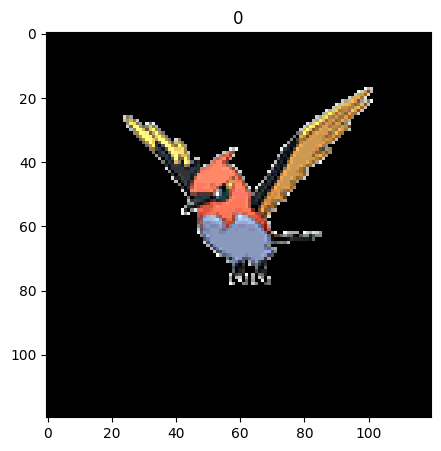

In [25]:
import random

x, name = dataset[random.randrange(0, len(dataset))]

print(x.shape)

plt.figure(figsize=(5, 5))
plt.imshow(torch.reshape(x, (120, 120, 3)))
plt.title(name)
plt.show()

In [26]:
transform = transforms.Compose([
    RandomHorizontalFlip(p=0.5),
#     RandomRotation(degrees=90),
#     RandomCrop(size=224),
#     ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    GaussianBlur(kernel_size=3)
])

augmented_samples = []
num_augmentations = 5

for image, label in dataset:
    for _ in range(num_augmentations):
        augmented_sample = transform(image)
        augmented_samples.append((augmented_sample, label))

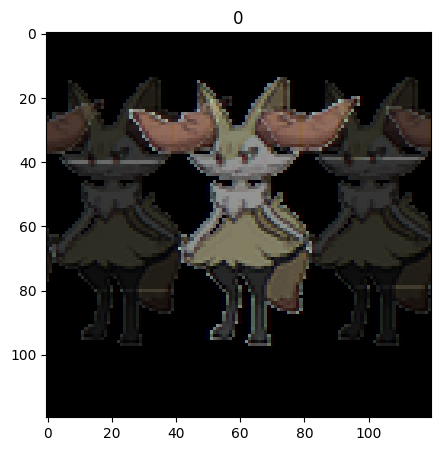

In [27]:
x, name = augmented_samples[random.randrange(0, len(augmented_samples))]

plt.figure(figsize=(5, 5))
plt.imshow(torch.reshape(x, (120, 120, 3)))
plt.title(name)
plt.show()

In [28]:
test_split = .2
shuffle_dataset = True

# dataset_size = len(combined_dataset)
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))

if shuffle_dataset:
    np.random.seed(42)
    np.random.shuffle(indices)
    
train_indices, test_indices = indices[split:], indices[:split]

train_indices[:5], test_indices[:5]

([24, 42, 105, 93, 36], [18, 45, 47, 89, 4])

In [29]:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 16

train_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
test_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, drop_last=True)

In [30]:
# вивести значення класів в батчах
for i, (img, t) in enumerate(train_dataloader):
    print(t)

tensor([0, 1, 0, 0, 2, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0])
tensor([2, 2, 0, 0, 0, 2, 0, 1, 0, 1, 0, 2, 2, 2, 0, 0])
tensor([0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 2, 0, 1])
tensor([0, 2, 0, 1, 1, 0, 1, 0, 2, 1, 2, 0, 0, 2, 0, 0])
tensor([0, 1, 1, 1, 1, 1, 1, 0, 2, 2, 0, 0, 1, 0, 1, 2])
tensor([1, 0, 1, 0, 0, 1, 1, 2, 2, 0, 1, 0, 1, 2, 2, 2])


In [31]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Convolutional layers
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Max-pooling layers
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = torch.nn.Linear(128 * 15 * 15, 256)
        self.fc2 = torch.nn.Linear(256, 3)  # 3 output classes
        
    def forward(self, x):
        # Convolutional layer 1
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        # Convolutional layer 2
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # Convolutional layer 3
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 128 * 15 * 15)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [32]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device {device}")

Using device cpu


In [33]:
for images, labels in train_dataloader:
    print(labels)

model_device = next(model.parameters()).device
input_device = images.device
print(f"model device: {model_device}")
print(f"input device: {input_device}")

tensor([1, 2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 2])
tensor([2, 1, 0, 1, 1, 0, 0, 0, 1, 2, 0, 1, 2, 1, 1, 2])
tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 2, 1, 2])
tensor([0, 1, 2, 1, 2, 0, 0, 0, 1, 0, 2, 2, 0, 0, 2, 2])
tensor([1, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 2, 1, 0, 0, 1])
tensor([1, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2])
model device: cpu
input device: cpu


In [34]:
def cnn_model_train(model, lr, num_epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses, epochs, accuracies = [], [], [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, labels.to(device))

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            # Update the training loss
            train_loss += loss.item() * images.size(0)
            
        print(f'epoch[{epoch+1}/{num_epochs}]\nloss: {train_loss}')
        print('-' * 30)

        # Compute the average training loss for this epoch
        train_loss = train_loss / len(train_dataloader.dataset)
    return model

In [35]:
cnn_model = NeuralNetwork().to(device)
print(model)

lr = 1e-3
num_epochs = 10
cnn_model_train(cnn_model, lr, num_epochs)

Sequential(
  (0): Linear(in_features=11, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)
epoch[1/10]
loss: 122.48794937133789
------------------------------
epoch[2/10]
loss: 103.68481636047363
------------------------------
epoch[3/10]
loss: 98.98950958251953
------------------------------
epoch[4/10]
loss: 97.59210968017578
------------------------------
epoch[5/10]
loss: 97.90419101715088
------------------------------
epoch[6/10]
loss: 94.34443950653076
------------------------------
epoch[7/10]
loss: 91.05142974853516
------------------------------
epoch[8/10]
loss: 87.47381973266602
------------------------------
epoch[9/10]
loss: 77.13828372955322
------------------------------
epoch[10/10]
loss: 67.52362966537476
------------------------------


NeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28800, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)

In [36]:
# Validation
cnn_model.eval()
val_loss = 0.0
correct = 0
total = 0
pokemon_true_labels = []
pokemon_predicted_labels = []
with torch.no_grad():
    for j, (images, labels) in enumerate(test_dataloader):            
        labels = labels.to(device)
        images = images.to(device)

        outputs = cnn_model(images)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        pokemon_true_labels.extend(labels.tolist())
        pokemon_predicted_labels.extend(predicted.tolist())

# pokemon_predicted_labels, pokemon_true_labels
print(classification_report(pokemon_true_labels, pokemon_predicted_labels, target_names=['Fire', 'Electric', 'Dark']))
# Training complete

              precision    recall  f1-score   support

        Fire       0.40      0.33      0.36         6
    Electric       0.00      0.00      0.00         3
        Dark       0.55      0.86      0.67         7

    accuracy                           0.50        16
   macro avg       0.32      0.40      0.34        16
weighted avg       0.39      0.50      0.43        16



D:\Programs\Miniconda3\envs\dl_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Miniconda3\envs\dl_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Miniconda3\envs\dl_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Завдання 3 (класифікація тексту, RNN)

In [37]:
text_filename = 'spam.csv'

encodings = ['utf-8', 'ISO-8859-1', 'latin1']

for encoding in encodings:
    try:
        text_dataset = pd.read_csv(text_filename, encoding=encoding)[['v1','v2']]
        break  # Stop trying encodings if successful
    except UnicodeDecodeError:
        continue

text_dataset['v2'] = text_dataset['v2'].map(lambda x: x.lower())


# 1. Tokenization
text_dataset['v2'] = text_dataset['v2'].apply(lambda x: x.split())

# 2. Removal of Punctuation
text_dataset['v2'] = text_dataset['v2'].apply(
    lambda tokens: [word.strip(string.punctuation) for word in tokens]
)

# 3. Stop Word Removal
stop_words = set(stopwords.words('english'))
text_dataset['v2'] = text_dataset['v2'].apply(
    lambda tokens: [word for word in tokens if word.lower() not in stop_words]
)

text_dataset['v1'] = text_dataset['v1'].map({'ham': 0, 'spam': 1})

text_dataset.head()

,v1,v2
0,0,"[go, jurong, point, crazy, available, bugis, n..."
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"[nah, think, goes, usf, lives, around, though]"


In [38]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(text_dataset['v2'].apply(' '.join))
y = text_dataset['v1']

train_text_tfidf, test_text_tfidf, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert TF-IDF vectors to PyTorch tensors
# train_text_tfidf = torch.from_numpy(train_text_tfidf.toarray()).float()
# test_text_tfidf = torch.from_numpy(test_text_tfidf.toarray()).float()
# y_train = torch.from_numpy(y_train.values).int()
# y_test = torch.from_numpy(y_test.values).int()

train_text_tfidf = torch.tensor(scipy.sparse.csr_matrix.todense(train_text_tfidf)).float()
test_text_tfidf = torch.tensor(scipy.sparse.csr_matrix.todense(test_text_tfidf)).float()
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

train_text_tfidf, y_train

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2559, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([0, 1, 0,  ..., 0, 0, 0]))

In [39]:
train_text_tfidf.shape, test_text_tfidf.shape

(torch.Size([4457, 8624]), torch.Size([1115, 8624]))

In [40]:
train_text_tfidf.shape, y_train.shape

(torch.Size([4457, 8624]), torch.Size([4457]))

In [41]:
class SelectState(nn.Module):
    def __init__(self, item_index):
        super(SelectState, self).__init__()
        self._name = 'selectstate'
        self.item_index = item_index

    def forward(self, inputs):
        return inputs[self.item_index]

In [42]:
def create_rnn_model(input_size, rnn_hidden, rnn_layers, output_size):
    layers = []
    layers.append(nn.RNN(input_size, rnn_hidden, num_layers=rnn_layers, batch_first=True, nonlinearity='relu'))
    layers.append(SelectState(0))  # Flatten the output
    layers.append(nn.Linear(rnn_hidden, output_size))
    model = nn.Sequential(*layers)
    return model

In [43]:
def train_rnn_model(model, train_iterator, lr, num_epochs):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        for batch in train_iterator:
            text, labels = batch
            text = text.to(device)
            labels = labels.type(torch.FloatTensor).to(device)

            optimizer.zero_grad()
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += ((predictions > 0.5) == labels).sum().item()

        epoch_loss = total_loss / len(train_iterator)
        epoch_acc = total_correct / len(train_iterator)
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {epoch_loss:.3f}')

    return model

In [44]:
train_data = torch.utils.data.TensorDataset(train_text_tfidf, y_train)
test_data = torch.utils.data.TensorDataset(test_text_tfidf, y_test)
train_iterator = torch.utils.data.DataLoader(train_data, batch_size=64)
test_iterator = torch.utils.data.DataLoader(test_data, batch_size=64)

In [45]:
input_size = train_text_tfidf.shape[1]
rnn_hidden = 64
rnn_layers = 3
output_size = 1

# rnn_model = create_rnn_model(input_size, rnn_hidden, rnn_layers, output_size)
# rnn_model
# rnn_model(train_text_tfidf[0:64]).shape

In [46]:
lr = 1e-3
num_epochs = 10

rnn_model = create_rnn_model(input_size, rnn_hidden, rnn_layers, output_size)
model = train_rnn_model(rnn_model, train_iterator, lr, num_epochs)

Epoch: 01
	Train Loss: 0.436
Epoch: 02
	Train Loss: 0.320
Epoch: 03
	Train Loss: 0.068
Epoch: 04
	Train Loss: 0.013
Epoch: 05
	Train Loss: 0.003
Epoch: 06
	Train Loss: 0.002
Epoch: 07
	Train Loss: 0.001
Epoch: 08
	Train Loss: 0.001
Epoch: 09
	Train Loss: 0.001
Epoch: 10
	Train Loss: 0.001


In [47]:
rnn_model.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test data
with torch.no_grad():
    for batch in test_iterator:
#         print(batch)
        text = batch[0]
        labels = batch[1]

        # Forward pass
        predictions = rnn_model(text).squeeze(1)

        # Round the predictions to 0 or 1
        predicted = torch.round(torch.sigmoid(predictions))

        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2%}')

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'])
print(report)

Accuracy: 96.86%
              precision    recall  f1-score   support

     Class 0       0.97      1.00      0.98       965
     Class 1       0.97      0.79      0.87       150

    accuracy                           0.97      1115
   macro avg       0.97      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115

